<h1> Inhaltsbasierte Suche in Bildern</h1>
<p style="font-size:18px">
Entwicklung eines Programms, welches anhand eines Filmposter die dazugehörigen Genres ermittelt.
</p>
<div style=" display: flex; 
    justify-content: center; 
    align-items: center;">
<img src="./vortrag/Aufgabe.png" alt="Aufagbe" width="300" height="400"  title=""/>
</div>

<h2> Inhaltsverzeichnis </h2>
<div style="font-size:18px">
    1. Motivation
    <br>
    2. Einordnung in das Thema Machine Learning 
    <br>
    3. Preprocessing
    <br>
    4. Neuronale Netze 
    <br>
    5. Demo
</div>

<h1>Motivation </h1>

<div style="font-size:18px;">
    1. Biologie <!-- Tierarten / Krebzellen -->
    <br>
    2. Werbung<!-- Poster / kommen die an bei den Kunden oder nicht  -->
</div>

<h1> Einordnung in das Thema Maschine Learning</h1>
<div style="font-size:18px">
Um Bilder zu Klassifizieren werden neuronale Netzte benutzt. Diese sind aus der Biologie bekannt. Es gibt verschiedenen <i>Neuronen</i> die miteinander <i>vernetzt</i> sind. Wie in der Biologie werden auch hier Neuronen aktiviert oder nicht, dies ist abhängig von den Werten die ans Neuron gesendet werden
</div>
<div style=" display: flex; 
    justify-content: center; 
    align-items: center;">
<img src="./vortrag/modell-architektur.png" alt="Aufagbe" width="650" height="300"  title=""/>
</div>
<br>
<br>
<br>
<div style=" display: flex; 
    justify-content: center; 
    align-items: center;">

</div>

<h1> Vorgehen </h1>
<div style="font-size:18px">
    1. Importieren der benötigen Bibliotheken
    <br>
    2. Laden der Daten
    <br>
    3. Datenbereinigung
    <br>
    4. Datenvorbereitung
    <br>
</div>

<h2> Importieren der benötigen Bibliotheken</h2>

In [111]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import shutil
import multiprocessing
import urllib.error
import urllib.request

from joblib import Parallel, delayed
from time import time


from datetime import datetime
from tensorflow.keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices())

2.9.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


<h2> Laden der CSV Datei </h2>
<p style="font-size:18px">
Die Daten bekommen wir von Kaggel. Kaggel bietet verschiedene CSV Dateien - zu allmöglichen Themen - , über die die Daten runtergeladen werden können an. 
</p>

In [112]:
movie_data = pd.read_csv("./data/MovieGenre.csv",
                          sep=",", encoding='unicode_escape', index_col=None)
movie_data.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


<h2> Erste Datenbereinigung </h2>
<p style="font-size:18px">
Löschen der Zeilen die einen Null Wert enthalten, da wir mit diesen Zeilen nichts anfangen können
</p>


In [113]:
# Entfernen von Null Werten
movie_data.dropna(subset=['imdbId', 'Genre', 'Poster'], inplace=True)

<h2> Herunterladen der Film Poster (Parallel)</h2>
<p style="font-size:18px">
Die Filmposter, die in der CSV Datei angegeben sind werden Heruntergeladen, dies passiert parallel damit dies schneller geht.
</p>



In [ ]:
def download_parallel(movies, image_dir):
    # Create list of filenames
    filenames = movies['imdbId'].apply(lambda imbdId : os.path.join(image_dir, str(imbdId)+'.jpg'))
    # Create list of image urls
    urls = movies['Poster']

    # Create destination directory
    if os.path.exists(image_dir):
        print("Directory '{}' already exists and will be deleted.".format(image_dir))
        shutil.rmtree(image_dir)
    print("Created new directory '{}'".format(image_dir))
    os.makedirs(image_dir)

    # Define function to download one single image
    def download_image(url, filename):
        try:
            urllib.request.urlretrieve(url, filename)
            return 0
        except:
            return os.path.basename(filename).split('.')[0]

    # Download images in parallel
    start = time()
    print("\nDownloading...")
    num_cores = multiprocessing.cpu_count()
    ko_list = Parallel(n_jobs=num_cores)(delayed(download_image)(u, f) for f, u in zip(filenames, urls))

    print("\nDownload in parallel mode took %d seconds." %(time()-start))
    print("Success:", len([i for i in ko_list if i==0]))
    print("Errors:", len([i for i in ko_list if i!=0]))

    # Remove not downloaded posters from the dataframe
    print("length of Movies before removing errors: " + str(len(movies)))
    imdbIdToBeRemoved = []
    for item in ko_list:
        if(item !=0):
            imdbIdToBeRemoved.append(item)
    movies= movies[~ movies["imdbId"].astype(str).isin(imdbIdToBeRemoved)]
    print("length of Movies after removing errors: " + str(len(movies)))

    return movies


destination = './data/movie-posters'
movie_data = download_parallel(movie_data, destination)

<h2> Erstellen einer neuen CSV Datei</h2>
<p style="font-size:18px">
In dieser CSV Datei stehen nur die Bilder, die wir auch heruntergeladen haben bzw. konten
</p>

In [ ]:
data_dir = "./data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
movie_data.to_csv(os.path.join(data_dir, "movies.csv"), index=False)

<h2>Zweite Datenbereinigung</h2>
<p style="font-size:18px">
Jetzt wo wir wissen welche Bilder wir haben, können wir eine zweite Datenbereitung machen und die Daten fürs Training vorbereiten <br>
<br>
 1. Wir zählen, wie oft ein Label vorkommt<br>
 2. Speichern alle Labels die weniger als 1000 mal vorkommen in einer Liste<br>
 3. Entfernen aller Labels die mit einem der Labels in der zuvor erstellten Liste übereinstimmen<br>
 4. Entfernen von einigen Dramen, da wir von diesen viel mehr Testdaten haben als von anderen<br>
 </p>



<div style="font-size:18px">Ermitteln der Genrehäufigkeiten</div>

In [114]:
movie_data = pd.read_csv("./data/movies.csv")

label_freq = movie_data['Genre'].apply(lambda s: str(s).split(
    '|')).explode().value_counts().sort_values(ascending=False)

<div style="font-size:18px">Erstellung einer Grafik der Genrehäufigkeiten</div>

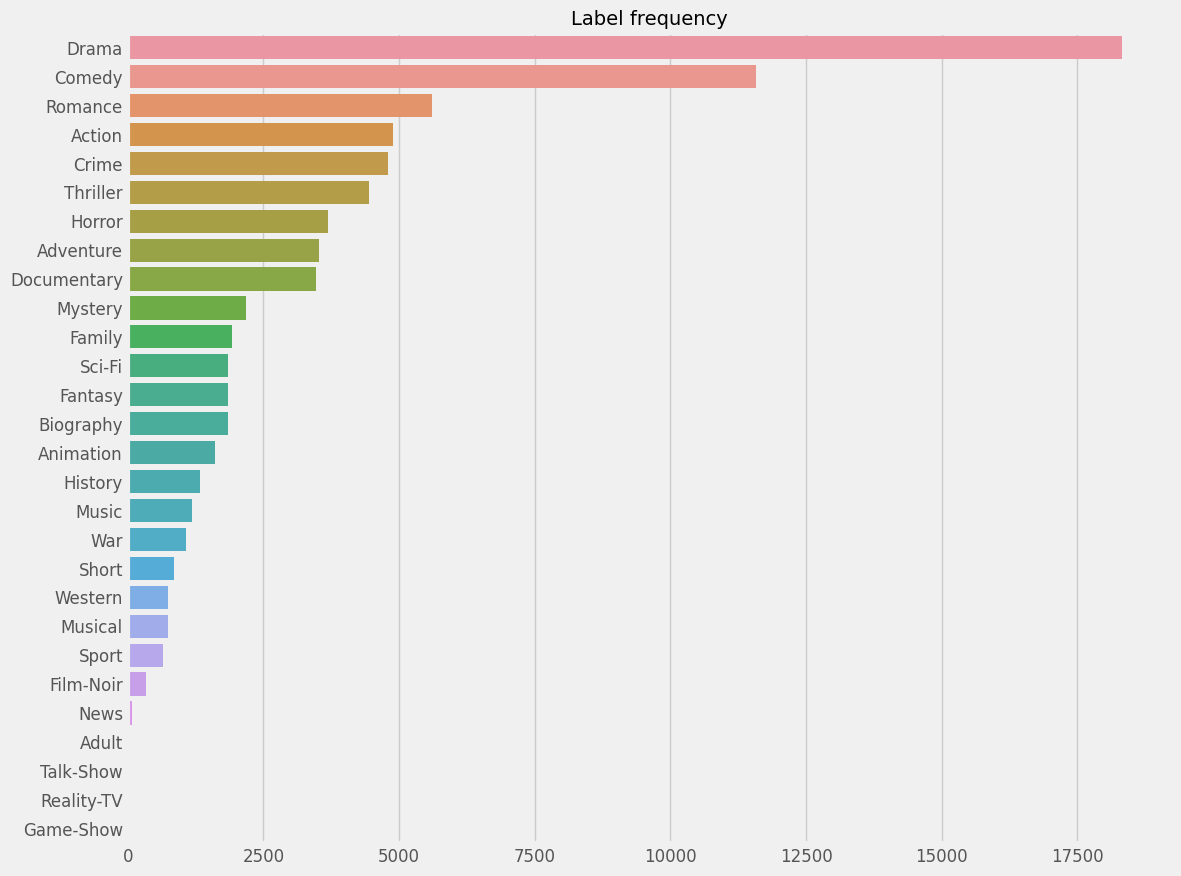

In [115]:
style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

<div style="font-size:18px">Entfernen von Filme mit keinem Genre und Filme aus dem Genre "Drama" (maximal 7000). <br> Dies hat den Hintergrund, damit nicht zu viele Daten eines Genres existieren</div>

In [116]:
rare = list(label_freq[label_freq < 1000].index)
display(rare)

print(f"Number of movie posters in last download: {len(movie_data)}")
movie_data['Genre'] = movie_data['Genre'].apply(
    lambda s: [l for l in str(s).split('|') if l not in rare])

empty_genres = movie_data["Genre"].apply(
    lambda x: not x)

movie_data = movie_data.drop(movie_data[empty_genres].index)
print(
    f"Number of movie posters after deleting empty genre movies: {len(movie_data)}")
DRAMA_REMOVE_COUNT = 7000
only_drama = movie_data["Genre"].apply(
    lambda x: all(g == "Drama" for g in x))
only_drama = only_drama[only_drama == True].iloc[0:DRAMA_REMOVE_COUNT]
movie_data = movie_data.drop(only_drama.index)
print(
    f"Number of movie posters after deleting {len(only_drama)} only drama movies: {len(movie_data)}")

movie_data.head(3)

['Short',
 'Western',
 'Musical',
 'Sport',
 'Film-Noir',
 'News',
 'Adult',
 'Talk-Show',
 'Reality-TV',
 'Game-Show']

Number of movie posters in last download: 36343
Number of movie posters after deleting empty genre movies: 35953
Number of movie posters after deleting 4231 only drama movies: 31722


,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,"[Animation, Adventure, Comedy]",https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,"[Action, Adventure, Family]",https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,"[Comedy, Romance]",https://images-na.ssl-images-amazon.com/images...


<h2> Daten aufteilen in Trainings- und Validierungsdaten.</h2>
<p style="font-size:20px">
    Die Filmposter werden aufgeteilt in 80% Trainingsdaten und 20% Validierungsdaten
</p>

In [118]:
X_train, X_val, y_train, y_val = train_test_split(movie_data['imdbId'], movie_data['Genre'], test_size=0.2, random_state=44)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

# we need files instead of imdbIds
X_train = [os.path.join('./data/movie-posters/', str(f)+'.jpg') for f in X_train]
X_val = [os.path.join('./data/movie-posters/', str(f)+'.jpg') for f in X_val]
print(X_train[:3])

y_train = list(y_train)
y_val = list(y_val)
print(y_train[:3])

Number of posters for training:  25377
Number of posters for validation:  6345
['./data/movie-posters/66374.jpg', './data/movie-posters/6038506.jpg', './data/movie-posters/80725.jpg']
[['Comedy', 'Drama'], ['Comedy'], ['Family', 'Fantasy', 'Comedy']]


<h2>Beispiel Bilder</h2>


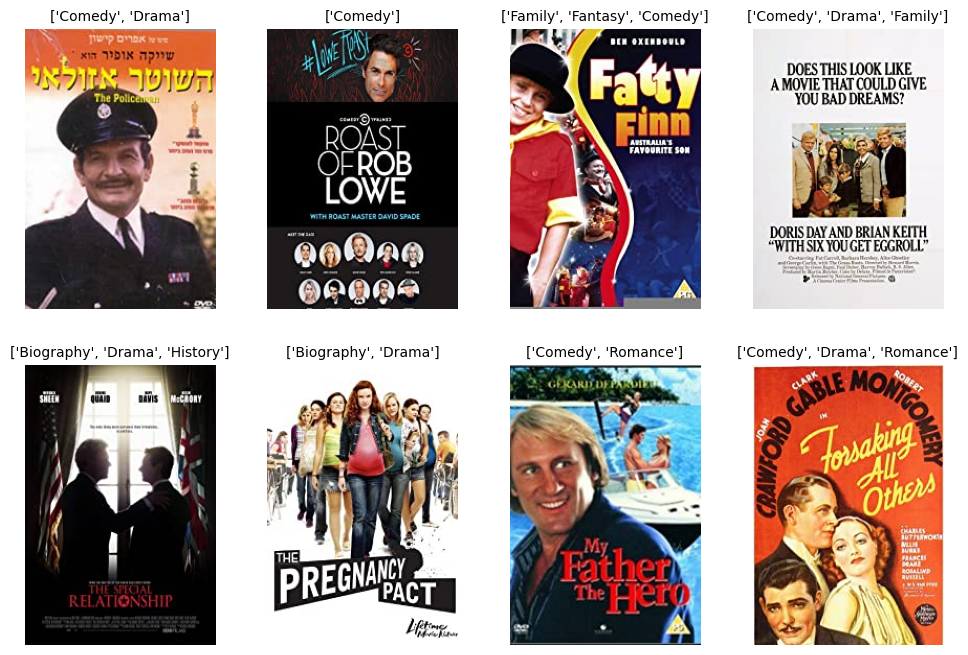

In [119]:
nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')

 <h2> Genre encoding</h2>
 <p style="font-size:20px">
 Das neuronale Netzt soll nach dem Klassifizieren uns für jedes Genre eine Wahrscheinlichkeit ausgeben. <br>
 Daher müssen wir zu jedem Film Speichern, ob es in einem Genre ist oder nicht.
 <br><br>
 <table>
    <tr>
        <th>Film</th>
        <th>Action</th>
        <th>Comedy</th>
        <th>Drama</th>
        <th>Adventure</th>
        <th>Crime</th>
    </tr>
    <tr>
        <td>The Shadow</td>
        <td>1</td>
        <td>0</td>
        <td>0</td>
        <td>1</td>
        <td>1</td>
    </tr>
</table>
 </p>

In [120]:
# Fit the multi-label binarizer on the training set
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

# Print example of movie posters and their binary targets
for i in range(3):
    print(X_train[i], y_train_bin[i])


Labels:
0. Action
1. Adventure
2. Animation
3. Biography
4. Comedy
5. Crime
6. Documentary
7. Drama
8. Family
9. Fantasy
10. History
11. Horror
12. Music
13. Mystery
14. Romance
15. Sci-Fi
16. Thriller
17. War
./data/movie-posters/66374.jpg [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
./data/movie-posters/6038506.jpg [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
./data/movie-posters/80725.jpg [0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0]


<h1>Aufbau des Neuronalen Netztes</h1>

<div style="font-size:20px">
    <ol>
    <li>Grundlagen</li>
    <li>Parameter das neuronale Netz festlegen</li>
    <li>Modell bauen</li>
    <li>Training</li>
    <li>Validierung</li>
    </ol>
</div>

<h3>Grundlagen</h3>
<div style="font-size:18px">
    <p>Ein <em>künstliches neuronales Netz</em> besteht aus Schichten künstlicher Neuronen, welche miteinander eine Eingabe verarbeiten und eine Ausgabe erzeugen können. Moderne künstliche neuronale Netze bestehen aus einer Vielzahl an Ebenen, welche alle bestimmte Funktionen erfüllen. Besonders prominent in der Bildklassifizierung sind <strong>Convolutional Neural Networks (CNN)</strong>, welche im Kern aus Convolutional Layers bestehen.</p>
    <figure style="text-align: center">
    <img src="./vortrag/typical_cnn.png" alt="Typical CNN" width="40%">
    <figcaption>Aufbau eines CNN [5]</figcaption>
    </figure>
    <h4>Convolutional Layer</h4>
    <p><em>Convolutional Layers</em> können mit Bildfiltern verglichen werden: Sie sind Matrizen, die über das Eingangsbild gelegt werden und mit einer Matrixkonvolution eine neue Matrix generieren können. Diese generierten Matrizen stellen Merkmale des Eingangsbildes dar, wie bspw. Kanten, Tiefen, Formen etc. Werden mehrere solcher Merkmale verwendet, kann ein künstliches neuronales Netz eine Verknüpfung zu dem Label des Bildes herstellen. <br><br> <a href="https://deeplizard.com/resource/pavq7noze2">Veranschaulichung von Filtern</a></p>
    <figure style="text-align: center">
    <img src="./vortrag/feature_maps.png" alt="Feature maps example" width="40%">
    <figcaption>Beispiel einer Feature Map [4]</figcaption>
    </figure>
    <h4>Aktivierungsfunktion</h4>
    Eine Aktivierungsfunktion transformiert verschiedene Eingabewerte auf Ausgabewerte. Eine oft verwendete Aktivierungsfunktion ist die <em>Rectified Linear Unit (ReLu)</em> Funktion, welche negative Werte neutralisiert und positive Werte beibehält</p>
    <figure style="text-align: center">
    <img src="./vortrag/relu.svg" alt="ReLu Funktion" width="40%">
    <figcaption>Rectified Linear Unit (ReLu) Funktion [6]</figcaption>
    </figure>
    <h4>MaxPooling Layer</h4>
    <p>Neben <em>Convolutional Layers</em> gibt es weitere Ebenen, wie dem MaxPooling. Diese unterstützen die Merkmalsextraktion, indem sie die herausgearbeiteten Merkmale verdeutlichen. Dabei können jedoch andere, möglicherweise weniger wichtige, Informationen verloren gehen. <br><br> <a href="https://deeplizard.com/resource/pavq7noze3">Veranschaulichung von MaxPooling Layern</a> </p>
    <h4>Dense Layer</h4>
    <p> <em>Dense Layer</em> (Fully-Connected-Layer) verbinden alle Neuronen mit allen Inputs und Outputs. Jeder der Verbindungen besitzt dabei ein Gewicht. Die Input werde werden mit der Gewichtung multipliziert und aktivieren dadruch manch andere Neuroen. Diese Neuronen erhalten wiederum wieder gewichte. Ob ein Neuron aktiviert wird hängt wieder von dem Ergebniss einer Aktivierungsfunktion ab.
    <figure style="text-align: center">
    <img src="./vortrag/activation.png" alt="Typical CNN" width="40%">
    <figcaption>Berechnung eines Neurons</figcaption>
    </figure>
    <p>Am Ausgang eines jeden künstlichen neuronalen Netzes sitzt eine Ebene, dessen Neuronenzahl der Anzahl an Labels entspricht. Auch hier wird eine Aktivierungsfunktion verwendet, allerdings eine, die die Zuordnung der vorherigen Werte zu einem Label ermöglichen, bpsw. anhand einer Wahrscheinlichkeit.</p>
    <h4>Dropout</h4>
    <p> Das Dropout Layer sorgt dafür, dass eine definierte Menge an Neuronen, die ausgeschaltet werden und von nachfolgenden Ebenen nicht berücksichtigt werden.</p>
    <h4>Batchnormalisation</h4>
    <p>Dieser Layer Normalisiert den Output eines Neurons während eines Batches. Verhindert besonders "starke" Neuronen, die den Traininsgprozess dominieren könnten</p>
    <h4>Metriken: Loss & Accuracy</h4>
    <p>Für das Training eines künstlichen neuronalen Netzes werden Metriken eingesetzt, die die Qualität des Netzes beschreiben. Loss beschreibt hierbei die Abweichung des ausgegebenen Labels vom künstlichen neuronalen Netzes von dem eigentlichen Label. Es beschreibt also, wie fehlerbehaftet das Netz arbeitet. Accuracy beschreibt, wie hoch der Anteil der richtig klassifizierten Daten im Vergleich zu allen Klassifizierungen ist.</p>
</div>

<div style=" display: flex; 
    justify-content: center; 
    align-items: center;">
<img src="./vortrag/cnn.png" alt="Aufagbe" width="1000" height="500"  title=""/>
</div>

<h2>Parameter fürs das neuronale Netz festelegen</h2>
<div style="font-size:18px">
IMG_SIZE = Die Breite und Höhe des Bildes. Bestimmt mit den Channels die Anzahl der Input Neuronen. (IMG_SIZE * IMG_SIZE * CHANNELS)
<br>
<br>
CHANNELS = Gibt an welches Farbschema unsere Daten haben z. B. 1 = Graustufen & 3 = RGB
<br>
<br>
BATCHSIZE = Anzahl an Film Poster die unser neuronales Netzt beim training versucht zu Klassifizieren bevor die Gewichte angepasst werden.
<br>
<br>
LEARNING_RATE = Die Learning Rate gibt an wie schnell unser neuronales Netzt lernt. 
<br>
<br>
EPOCHES = Anzahl an Trainingsdurchläufe
</div>

In [121]:
IMG_SIZE = 224 # Height and Width of an Image
CHANNELS = 3 # 3 Stands for RGB
# 224*224*3

BATCH_SIZE = 50 # Number of learning repetitions
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
TRAINABLE = True

LEARNING_RATE = 9e-3
EPOCHS = 30
model_name="mobilenet"

In [122]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.4),
        layers.RandomZoom(0.4),
    ]
)

def parse_function(filename, label):
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

def create_dataset(filenames, labels, is_training=True, augment=False):
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)

    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x), y))
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

train_ds = create_dataset(X_train, y_train_bin, augment=True)
val_ds = create_dataset(X_val, y_val_bin)

for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)
print(f"Length of train data: {len(train_ds)}")
print(f"Length of val data: {len(val_ds)}")

Shape of features array: (50, 224, 224, 3)
Shape of labels array: (50, 18)
Length of train data: 508
Length of val data: 127


2022-06-06 12:04:18.114962: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<h2>Vortrainiertes Modell herunterladen</h2>
<div style="font-size:18px">
Mobilenet bietet viele verschiedene vortrainierte neuronale Netze an, die bereits verschiedene Objekte erkennen können
</div>

In [13]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))
                                         #mobilenet vorstellen
feature_extractor_layer.trainable = TRAINABLE

<h2>Model zusammenbauen</h2>

In [14]:
model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.BatchNormalization(),
        layers.Dropout(0.6),
        layers.Dense(1024, activation='relu'),
        layers.Dense(N_LABELS, activation='sigmoid')
])

<h2> Parameter speichern (fürs Training & Testen )</h2>

In [15]:
with open(f"./data/models/{model_name}.txt",'w') as fh:
    fh.write(f'BATCH_SIZE = {str(BATCH_SIZE)} \n')
    fh.write(f'EPOCHS = {str(EPOCHS)} \n')
    fh.write(f'LEARNING_RATE = {str(LEARNING_RATE)} \n')
    fh.write(f'TRAINABLE = {str(TRAINABLE)} \n')
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

<h2>Model Trainieren</h2>

In [ ]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
loss = tf.keras.metrics.binary_crossentropy

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"])

start = time()
history = model.fit(train_ds,epochs=EPOCHS,validation_data=create_dataset(X_val, y_val_bin))

<h2> Graphische Veranschaulichung wie gut unser Model gelernt hat</h2>

In [16]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), history.history["val_accuracy"], label="val_acc")

plt.title("Training loss and accuracy on genre classification")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(f"./data/models/{model_name}")


NameError: name 'history' is not defined

<Figure size 640x480 with 0 Axes>

<h2>Sichern des trainierten Models</h2>
<p style="font-size:18px">
Sicher des tranierten Models, um dieses benutzen zu können wenn Film Poster Klassifizieren möchten.
</p>

In [ ]:
model_dir = "./data/models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(f"{model_dir}/{model_name}.h5",save_format="h5")

<h1>Demo</h1>

<h2>Verschiedene Film Poster vorbereiten</h2>
<div style="font-size:18px"> Film Poster die das Model noch nicht kennengelernt hat vorbereiten, damit diese Klassifiziert werden können
</div>

In [70]:
def prepare_user_images(filename, label, movie_name):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_normalized = image_resized / 255.0
    image_normalized = np.expand_dims(image_normalized, axis=0)
    return image_normalized, label, movie_name


example_filenames_labels = [
    {
        "file": "./data/validationImages/Avengers-Action-Science-Fiction.jpg",
        "labels": ["Action", "Science-Fiction", "Abenteuer"],
        "name": "Avengers"
    },
    {
        "file": "./data/validationImages/crazyStupidLove-Romanze-Komödie.jpg",
        "labels": ["Romanze", "Komödie"],
        "name":"Crazy Stupid Love"
    },
    {
        "file": "./data/validationImages/matrix_action_scifi_abenteuer_fantasy.jpeg",
        "labels": ["Fantasy", "Action", "Science-Fiction", "Abenteuer"],
        "name":"Matrix"
    },
    {
        "file": "./data/validationImages/batman_action_thriller_drama_abendteuer_.jpg",
        "labels": ["Action", "Thriller", "Drama", "Abenteuer", "Krimi", "Mystery"]
        "name":"Batman the dark knight"
    }
]
movies_to_predict = []
for movie in example_filenames_labels:
    movies_to_predict.append(prepare_user_images(
        movie["file"], movie["labels"], movie["name"]))


<h2>Poster Klassifizieren lassen</h2>

In [109]:
final_model = "mobilenet_trainable"
has_custom_layer = True

In [110]:
model = tf.keras.models.load_model(
    f"./data/models/{final_model}.h5", custom_objects={"KerasLayer": feature_extractor_layer})


for file, labels, name in movies_to_predict:
    display("--------------" + name + "------------------")
    prediction = (model.predict(file) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction == 1].index.values

    display("Prediction: " + str(list(prediction)))
    display("Actual: " + str(list(labels)))


'--------------Avengers------------------'

1/1 [==============================] - 1s 853ms/step


"Prediction: ['Comedy']"

"Actual: ['Action', 'Science-Fiction']"

'--------------Crazy Stupid Love------------------'

1/1 [==============================] - 0s 54ms/step


"Prediction: ['Comedy']"

"Actual: ['Romanze', 'Komödie']"

'--------------Matrix------------------'

1/1 [==============================] - 0s 52ms/step


"Prediction: ['Comedy', 'Crime']"

"Actual: ['Fantasy', 'Action', 'Science-Fiction', 'Abenteuer']"

'--------------Batman the dark knight------------------'

1/1 [==============================] - 0s 50ms/step


"Prediction: ['Comedy', 'Crime', 'Documentary']"

"Actual: ['Action', 'Thriller', 'Drama', 'Abenteuer']"

<h1>Quellen</h1>

- https://projectbase.medien.hs-duesseldorf.de/eild.nrw-module/lernmodul-bilder
- https://deeplizard.com/
- https://github.com/ashrefm/multi-label-soft-f1
- [4] https://tex.stackexchange.com/questions/91566/syntax-similar-to-centering-for-right-and-left
- [5] Aphex34, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons
- [6] Laughsinthestocks, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons